In [23]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

In [4]:
ROOT = '/Users/wubai.zhou/Uber/kaggle'
DATA_DIR = ROOT + '/data/'

In [6]:
train_files = glob.glob(DATA_DIR + 'stage1_train/*/images/*.png')

In [9]:
len(train_files)

670

In [45]:
training_sorted = sorted(train_files)
img_path = training_sorted[45]
img_path

'/Users/wubai.zhou/Uber/kaggle/data/stage1_train/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28/images/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28.png'

In [47]:
img_id = img_path.split('/')[-3]
img_id

'10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28'

In [13]:
img = mpimg.imread(img_path)
print(img.shape)

(520, 696, 4)


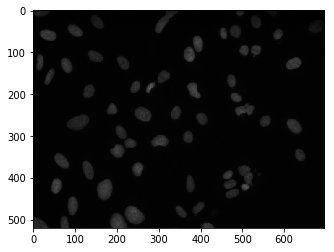

In [14]:
plt.imshow(img)
plt.show()

In [15]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
print(img_gray.shape)

(520, 696)


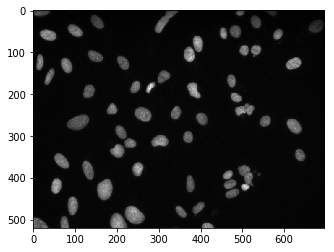

In [17]:
plt.imshow(img_gray, cmap='gray')
plt.show()

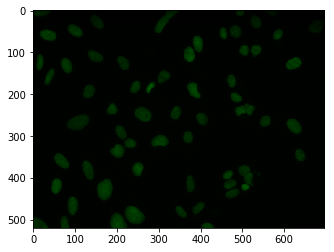

In [20]:
img_RGB = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
plt.imshow(img_HLS)
plt.show()

In [52]:
from skimage.filters import threshold_otsu
from scipy import ndimage
from utils import rle_encoding

thresh_val = threshold_otsu(img_gray)
mask = np.where(img_gray > thresh_val, 1, 0)

# make large portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

labels, nlabels = ndimage.label(mask)
label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


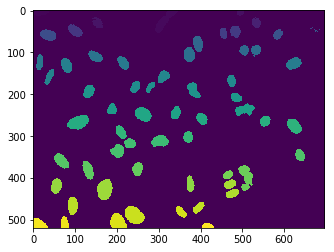

In [32]:
plt.imshow(labels)
plt.show()

In [33]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = img_gray[label_coords]
    
    # check if the label size is too small
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind + 1, 0, mask)

# regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


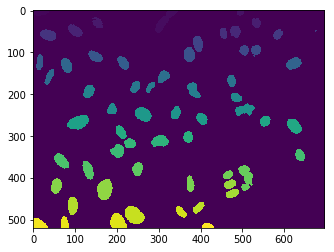

In [34]:
plt.imshow(labels)
plt.show()

In [56]:
import pandas as pd

def analyze_image(img_path):
    '''
    Take an image_path, preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    
    img_id = img_path.split('/')[-3]
    img = mpimg.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(img_gray)
    mask = np.where(img_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    img_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': img_id, 'EncodedPixels': rle})
            img_df = img_df.append(s, ignore_index=True)
    
    return img_df


def analyze_list_of_images(img_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for img_path in img_path_list:
        img_df = analyze_image(img_path)
        all_df = all_df.append(img_df, ignore_index=True)
    
    return all_df

In [49]:
test_files = glob.glob(DATA_DIR + 'stage1_test/*/images/*.png')
len(test_files)

65

In [57]:
df = analyze_list_of_images(test_files)
df.to_csv('submission.csv', index=None)

In [59]:
df.loc[0, 'EncodedPixels']

'57350 7 57604 10 57859 10 58114 12 58370 13 58625 14 58882 13 59137 14 59393 14 59650 12 59906 10 60162 8 60418 6 60675 4'